### Importing the data

In [1]:
# #Extracting the images
# import tarfile

# #file downloaded from http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar and saved as 'stanford_dogs_images.tar'

# #Extraction of folders of images
# # my_tar = tarfile.open('stanford_dogs_images.tar')
# # my_tar.extractall('./stanford_dogs_images') # specify which folder to extract to (pc)

# my_tar = tarfile.open("/content/stanford_dogs_images.tar")
# my_tar.extractall('/content/standford_dogs_images') # specify which folder to extract to (google colab)
# my_tar.close()


In [38]:
random_seed=1994

In [62]:
import os
import tensorflow as tf

from skimage import io
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import utils, applications, Input
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns


In [40]:
N_Breeds=20
Batch_Size=64
Epochs=30

In [41]:
#Dataset downloaded from: http://vision.stanford.edu/aditya86/ImageNetDogs/
fpath = "./stanford_dogs_images/Images/" #Place where all the folders of images are stored (pc)
#fpath = "/content/standford_dogs_images/Images" #google colab

breeds_folders = os.listdir(fpath) #names of the folders for each breed

#transforming to just the name of the breeds:
breeds=[]
for name in breeds_folders:
    breeds+=[name[10:]]

print("Number of breeds in dataset: ",len(breeds))


Number of breeds in dataset:  120


In [42]:
#Checking the number of images of dogs per breed
imagesinside=0
imagesperbreed=[]
for i, breedfolder in enumerate(breeds_folders):
    for image in os.listdir(fpath+"/"+breedfolder):
        imagesinside+=1
    imagesperbreed+=[imagesinside]
    imagesinside=0

about_each_breed=pd.DataFrame(list(zip(breeds_folders,breeds,imagesperbreed)),columns=["BreedsPath","Breed","Number of Images"])
about_each_breed["original_order"]=about_each_breed.index+1 #Adding column to know the original order of the folders


In [43]:
#Start and finish of rows selected
start=int((len(breeds)/2)-(N_Breeds/2)-2)
end=int((len(breeds)/2)+(N_Breeds/2)-2)

about_each_breed_ordered=about_each_breed.sort_values(by=["Number of Images"],ascending=False).reset_index().drop(columns=["index"])
Preselected=about_each_breed_ordered.iloc[start:end-1]
MiniSch=about_each_breed_ordered[about_each_breed_ordered["Breed"]=="miniature_schnauzer"] #82

#Ok, so why the Schnauzers should be in my analysis. Because, the best dog in the whole world, my Milo, is a mini Schnauzer :)
the_Selected_dogs=pd.concat([Preselected, MiniSch], ignore_index=True, sort=False)

print("Number of breeds selected for analysis: ",len(the_Selected_dogs))

Number of breeds selected for analysis:  20


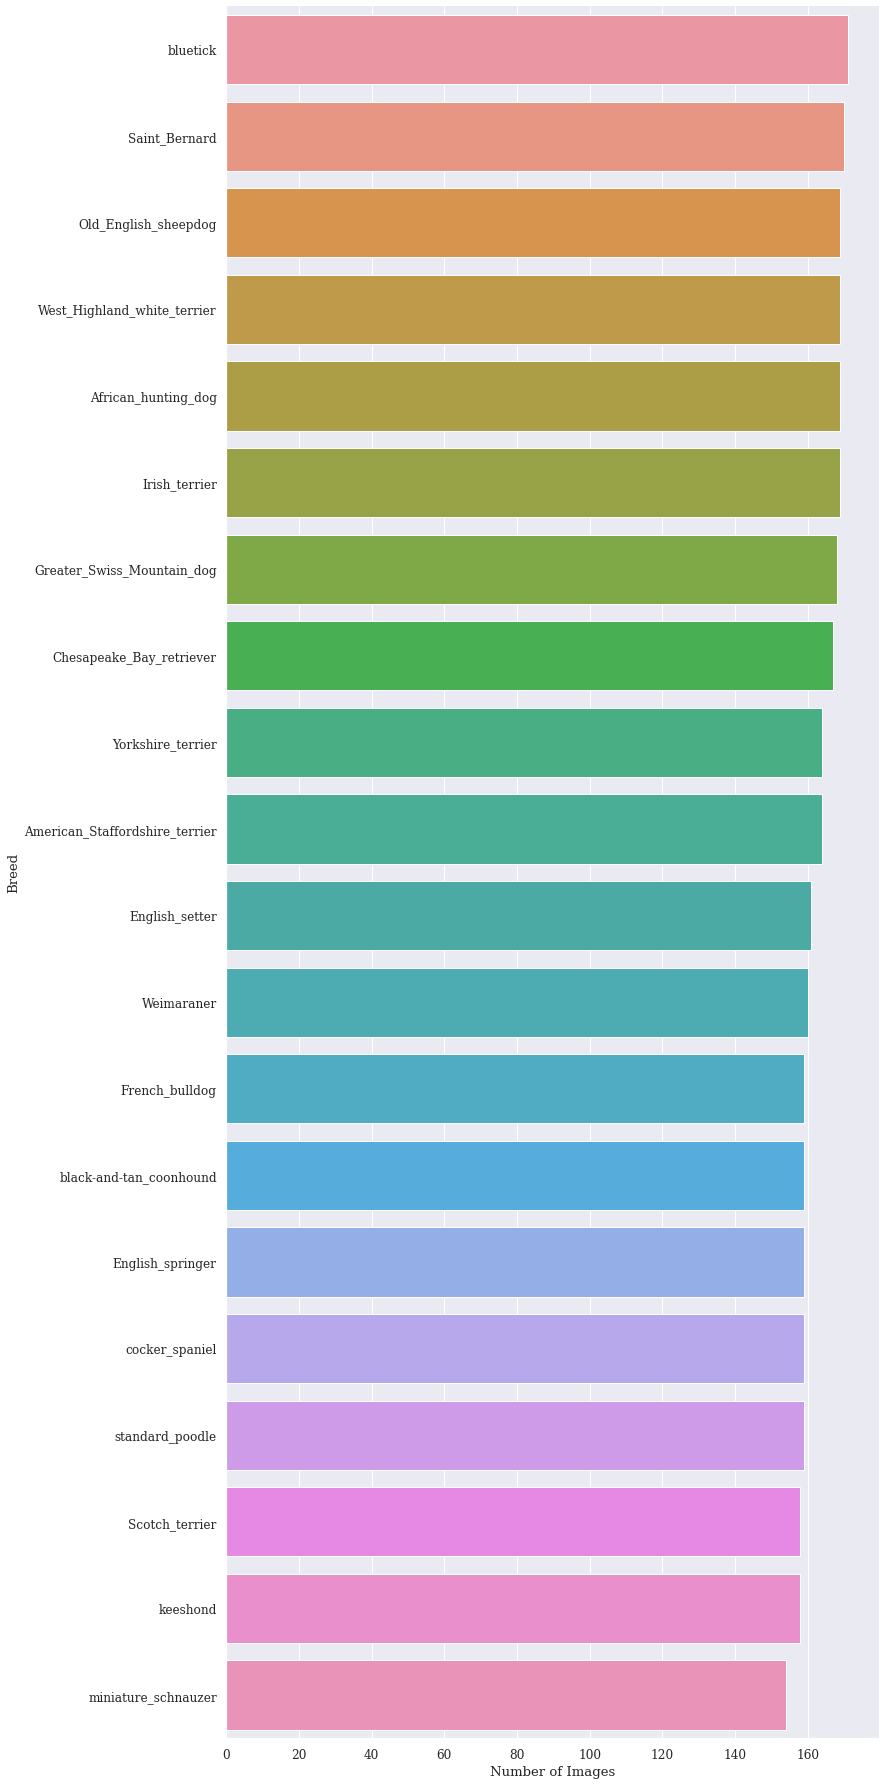

In [9]:
sns.set_theme(style="darkgrid",font_scale=1.1,font="serif")
sns.catplot(y="Breed", x="Number of Images",data=the_Selected_dogs,
            kind="bar",orient="h",height=25, aspect=0.5)

plt.show()

In [44]:
#This function performs the following actions:
#1 Reads every image from every folder of each breed
#2 Resizes the images
#3 Puts all the images and labels of each image in a numpy array

def LoadingImagesResizingAndLabels(breeds_folders,lenght,width):
    theimages=[]
    thelabels=[]
    for i, breedfolder in enumerate(breeds_folders): #names of the folders for each breed
        print(breedfolder,"...")
        for image_name in os.listdir(fpath+"/"+breedfolder): #names for each image inside the folders
            img = io.imread(fpath+"/"+breedfolder+"/"+image_name) #load image from file in RGB
            rezised=resize(img,(lenght,width)) #resizing image
            theimages.append(np.array(rezised)) #appending the images
            thelabels.append(i) #appending the labels
    imagesnp = np.array(theimages) #transforming list of images to numpy array
    labelsnp = np.array(thelabels) #transforming list of images to numpy array

    print("Number of Images:",len(imagesnp))
    print("Number of Breeds:",len(breeds_folders))
    print("Size of each image:",lenght,",",width)
    return imagesnp, labelsnp

In [45]:
#Loading the images, resizing them, and loading the labels:
lenght=224
width=224
images, labels = LoadingImagesResizingAndLabels(the_Selected_dogs["BreedsPath"],lenght,width)

n02088632-bluetick ...
n02109525-Saint_Bernard ...
n02105641-Old_English_sheepdog ...
n02098286-West_Highland_white_terrier ...
n02116738-African_hunting_dog ...
n02093991-Irish_terrier ...
n02107574-Greater_Swiss_Mountain_dog ...
n02099849-Chesapeake_Bay_retriever ...
n02094433-Yorkshire_terrier ...
n02093428-American_Staffordshire_terrier ...
n02100735-English_setter ...
n02092339-Weimaraner ...
n02108915-French_bulldog ...
n02089078-black-and-tan_coonhound ...
n02102040-English_springer ...
n02102318-cocker_spaniel ...
n02113799-standard_poodle ...
n02097298-Scotch_terrier ...
n02112350-keeshond ...
n02097047-miniature_schnauzer ...
Number of Images: 3266
Number of Breeds: 20
Size of each image: 224 , 224


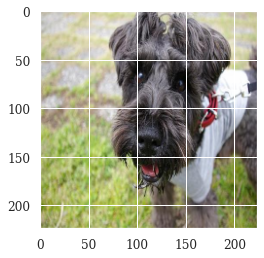

In [18]:
plt.imshow(images[-9])
plt.show()

In [102]:
#Creating a binary class matrix with the breed types:
label_output_matrix = utils.to_categorical(labels, num_classes = N_Breeds)

In [103]:
# Dividing data into training and testing (stratified)
X_train, X_test, y_train, y_test = train_test_split(images, label_output_matrix, test_size=0.2, random_state=random_seed,stratify=label_output_matrix)

#For data augmentation, we also need validation set:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_seed,stratify=y_train)

# from keras.utils import np_utils
print("For training without data augmentation:")
print("x_train shape = ",X_train.shape)
print("y_train shape = ",y_train.shape)

print("\nFor training with data augmentation:")
print("x_train2 shape = ",X_train2.shape)
print("y_train2 shape = ",y_train2.shape)
print("\nx_val shape = ",X_val.shape)
print("y_val shape = ",y_val.shape)

print("\nFor both cases:")
print("\nx_test shape = ",X_test.shape)
print("y_test shape = ",y_test.shape)


For training without data augmentation:
x_train shape =  (2612, 224, 224, 3)
y_train shape =  (2612, 20)

For training with data augmentation:
x_train2 shape =  (2089, 224, 224, 3)
y_train2 shape =  (2089, 20)

x_val shape =  (523, 224, 224, 3)
y_val shape =  (523, 20)

For both cases:

x_test shape =  (654, 224, 224, 3)
y_test shape =  (654, 20)


In [ ]:
# #LeNet
# model = Sequential()
# # CONV => RELU => POOL
# model.add(Conv2D(20, kernel_size=5, padding="same", input_shape=(lenght,width,3)))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# # CONV => RELU => POOL
# model.add(Conv2D(50, kernel_size=5, padding="same"))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# # Flatten => RELU layers
# model.add(Flatten())
# model.add(Dense(500))
# model.add(Activation("relu"))

# # a softmax classifier
# model.add(Dense(N_Breeds))
# model.add(Activation("softmax"))

In [14]:
def AlexNet():
    #AlexNet2012
    model = Sequential()
    #1 CONV => RELU => POOL => NORMALIZATION
    model.add(Conv2D(96, kernel_size=11, padding="valid",strides=(4,4), input_shape=(lenght,width,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(5,5), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    #2 CONV => RELU => POOL => NORMALIZATION
    model.add(Conv2D(256, kernel_size=5, strides=(1,1), padding="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    #3,4,5 CONV => RELU => NORMALIZATION
    model.add(Conv2D(384, kernel_size=3, strides=(1,1), padding="valid"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())

    model.add(Conv2D(384, kernel_size=3, strides=(1,1), padding="valid"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())

    model.add(Conv2D(256, kernel_size=3, strides=(1,1), padding="valid"))
    model.add(Activation("relu"))

    # POOL => NORMALIZATION
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Flatten => RELU layers => Dropout => Normalization
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())


    # Flatten => RELU layers => Dropout => Normalization
    model.add(Dense(4096))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())


    # a softmax classifier
    model.add(Dense(N_Breeds))
    model.add(Activation("softmax"))

    #Compiling the model
    model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return model

In [15]:
m=AlexNet()
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 25, 25, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 21, 21, 256)       0

### AlexNet Results (Without data Augmentation) batch=64

In [16]:
model1=AlexNet()
history = model1.fit(X_train, y_train, batch_size=Batch_Size, epochs=Epochs, verbose=1, validation_split=0.2)

Epoch 1/30
33/33 [==============================] - 32s 932ms/step - loss: 4.1740 - categorical_accuracy: 0.0938 - val_loss: 93.1677 - val_categorical_accuracy: 0.0421
Epoch 2/30
33/33 [==============================] - 28s 837ms/step - loss: 3.5053 - categorical_accuracy: 0.1273 - val_loss: 9.7613 - val_categorical_accuracy: 0.0554
Epoch 3/30
33/33 [==============================] - 28s 847ms/step - loss: 3.1631 - categorical_accuracy: 0.1675 - val_loss: 5.3283 - val_categorical_accuracy: 0.0994
Epoch 4/30
33/33 [==============================] - 28s 839ms/step - loss: 3.0611 - categorical_accuracy: 0.1881 - val_loss: 3.6531 - val_categorical_accuracy: 0.1281
Epoch 5/30
33/33 [==============================] - 28s 848ms/step - loss: 2.9397 - categorical_accuracy: 0.2082 - val_loss: 3.6340 - val_categorical_accuracy: 0.1052
Epoch 6/30
33/33 [==============================] - 28s 850ms/step - loss: 2.8162 - categorical_accuracy: 0.2336 - val_loss: 3.7571 - val_categorical_accuracy: 0.13

21/21 [==============================] - 2s 74ms/step - loss: 5.8075 - categorical_accuracy: 0.2615

Test score/loss: 5.807485103607178
Test accuracy: 0.26146790385246277
dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


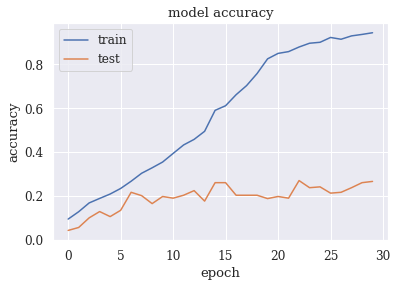

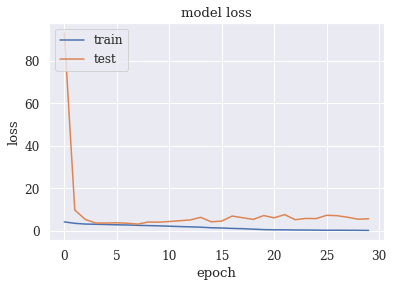

In [18]:
score = model1.evaluate(X_test, y_test, verbose=1)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
from sklearn import metrics
label_pred = model1.predict(X_test)
pred = []

for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index


print(metrics.classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.12      0.09      0.10        34
           1       0.50      0.35      0.41        34
           2       0.33      0.47      0.39        34
           3       0.16      0.26      0.20        34
           4       0.25      0.56      0.34        34
           5       0.33      0.56      0.42        34
           6       0.54      0.21      0.30        34
           7       0.31      0.15      0.20        33
           8       0.58      0.21      0.31        33
           9       0.11      0.06      0.08        33
          10       0.04      0.03      0.03        32
          11       0.16      0.09      0.12        32
          12       0.13      0.12      0.13        32
          13       0.31      0.12      0.18        32
          14       0.33      0.41      0.36        32
          15       0.16      0.28      0.20        32
          16       0.13      0.12      0.13        32
          17       0.47    

The model is overfitted

### AlexNet Results (With data augmentation) batch=64

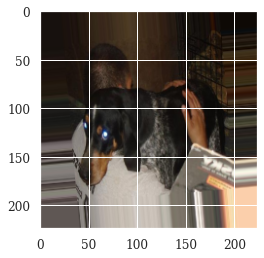

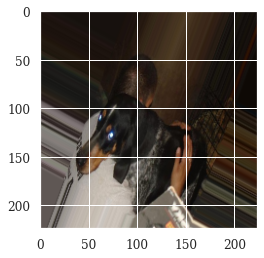

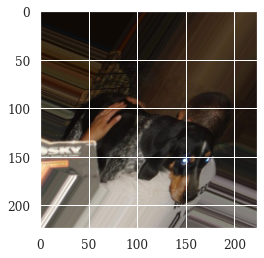

In [20]:
# From https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# To try to see the data generator effects
# example:
from numpy import expand_dims

from keras.preprocessing.image import ImageDataGenerator

data = images[1]

#expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=0.03,height_shift_range=0.3,fill_mode="nearest",
							horizontal_flip=True,rotation_range=30,zoom_range=[1.2,1.7])


# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(3):
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0]
	# plot raw pixel data
	plt.imshow(image)
	# show the figure
	plt.show()

In [37]:
from keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
datagen = ImageDataGenerator(fill_mode="nearest",horizontal_flip=True,rotation_range=40,zoom_range=[1.0,1.5])

# create the iterator
it = datagen.flow(X_train2,y_train2)

# step_per_epoch=int(len(X_train)/Batch_Size) #Num of batches of samples comprising one epoch
step_per_epoch=60


In [38]:
model2=0 #to reset
model2=AlexNet()
history = model2.fit(it,steps_per_epoch=step_per_epoch, batch_size=Batch_Size, epochs=Epochs, verbose=1,validation_data=(X_val, y_val))

Epoch 1/30
60/60 [==============================] - 50s 823ms/step - loss: 4.3469 - categorical_accuracy: 0.0854 - val_loss: 45.2757 - val_categorical_accuracy: 0.0707
Epoch 2/30
60/60 [==============================] - 38s 632ms/step - loss: 3.7436 - categorical_accuracy: 0.1083 - val_loss: 9.0792 - val_categorical_accuracy: 0.0975
Epoch 3/30
60/60 [==============================] - 37s 612ms/step - loss: 3.7057 - categorical_accuracy: 0.1107 - val_loss: 3.9026 - val_categorical_accuracy: 0.1071
Epoch 4/30
60/60 [==============================] - 36s 591ms/step - loss: 3.4961 - categorical_accuracy: 0.1176 - val_loss: 4.2871 - val_categorical_accuracy: 0.0937
Epoch 5/30
60/60 [==============================] - 35s 588ms/step - loss: 3.5423 - categorical_accuracy: 0.1154 - val_loss: 3.8439 - val_categorical_accuracy: 0.1166
Epoch 6/30
60/60 [==============================] - 36s 589ms/step - loss: 3.4947 - categorical_accuracy: 0.1302 - val_loss: 5.1700 - val_categorical_accuracy: 0.07

21/21 [==============================] - 2s 72ms/step - loss: 3.2805 - categorical_accuracy: 0.2232

Test score/loss: 3.2804794311523438
Test accuracy: 0.22324159741401672
dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


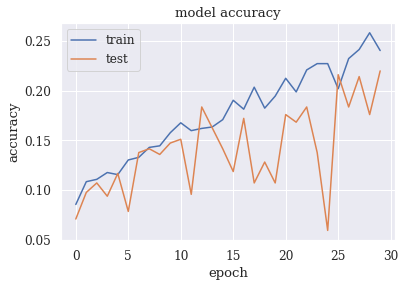

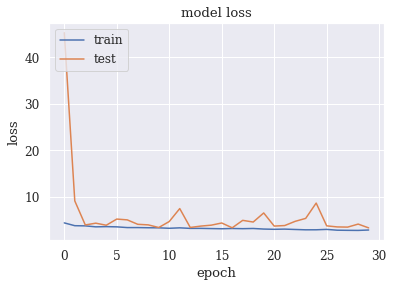

In [39]:
score = model2.evaluate(X_test, y_test, verbose=1)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
from sklearn import metrics
label_pred = model2.predict(X_test)
pred = []

for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index


print(metrics.classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.30      0.26      0.28        34
           1       0.07      0.06      0.06        34
           2       0.36      0.12      0.18        34
           3       0.16      0.18      0.17        34
           4       0.39      0.53      0.45        34
           5       0.45      0.50      0.47        34
           6       0.31      0.32      0.32        34
           7       0.15      0.09      0.11        33
           8       0.19      0.21      0.20        33
           9       0.11      0.03      0.05        33
          10       0.00      0.00      0.00        32
          11       0.09      0.03      0.05        32
          12       0.10      0.16      0.12        32
          13       0.31      0.34      0.33        32
          14       0.16      0.28      0.21        32
          15       0.18      0.09      0.12        32
          16       0.17      0.16      0.16        32
          17       0.31    

### AlexNet Results (Without data Augmentation) batch=32

In [41]:
model3=0 #to reset
model3=AlexNet()
history = model3.fit(X_train, y_train, batch_size=32, epochs=Epochs, verbose=1, validation_split=0.2)

Epoch 1/30
66/66 [==============================] - 37s 547ms/step - loss: 4.1990 - categorical_accuracy: 0.0905 - val_loss: 42.6883 - val_categorical_accuracy: 0.0593
Epoch 2/30
66/66 [==============================] - 35s 525ms/step - loss: 3.6495 - categorical_accuracy: 0.1139 - val_loss: 4.6856 - val_categorical_accuracy: 0.1185
Epoch 3/30
66/66 [==============================] - 34s 521ms/step - loss: 3.4333 - categorical_accuracy: 0.1321 - val_loss: 4.1190 - val_categorical_accuracy: 0.1358
Epoch 4/30
66/66 [==============================] - 33s 494ms/step - loss: 3.3730 - categorical_accuracy: 0.1561 - val_loss: 3.6221 - val_categorical_accuracy: 0.1549
Epoch 5/30
66/66 [==============================] - 32s 491ms/step - loss: 3.3597 - categorical_accuracy: 0.1489 - val_loss: 3.6241 - val_categorical_accuracy: 0.1530
Epoch 6/30
66/66 [==============================] - 32s 490ms/step - loss: 3.2946 - categorical_accuracy: 0.1623 - val_loss: 5.2867 - val_categorical_accuracy: 0.14

21/21 [==============================] - 2s 74ms/step - loss: 5.2419 - categorical_accuracy: 0.2661

Test score/loss: 5.241946220397949
Test accuracy: 0.26605504751205444
dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


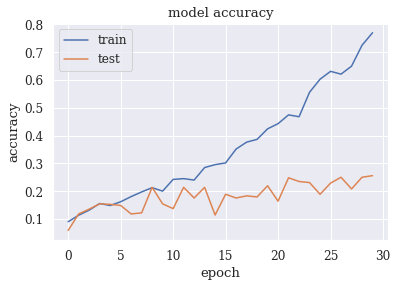

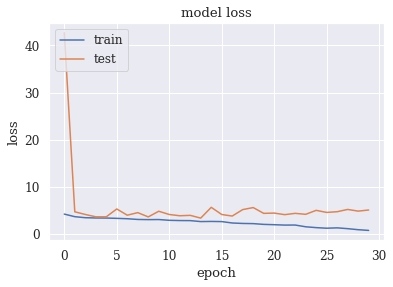

              precision    recall  f1-score   support

           0       0.20      0.26      0.23        34
           1       0.45      0.29      0.36        34
           2       0.45      0.26      0.33        34
           3       0.30      0.26      0.28        34
           4       0.43      0.35      0.39        34
           5       0.36      0.15      0.21        34
           6       0.23      0.38      0.29        34
           7       0.27      0.27      0.27        33
           8       0.28      0.24      0.26        33
           9       0.19      0.15      0.17        33
          10       0.18      0.19      0.18        32
          11       0.20      0.31      0.25        32
          12       0.14      0.12      0.13        32
          13       0.29      0.50      0.36        32
          14       0.31      0.31      0.31        32
          15       0.11      0.09      0.10        32
          16       0.12      0.12      0.12        32
          17       0.36    

In [42]:
score = model3.evaluate(X_test, y_test, verbose=1)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

from sklearn import metrics
label_pred = model3.predict(X_test)
pred = []

for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index


print(metrics.classification_report(Y_test, pred))

### AlexNet Results (With data augmentation) batch=32

In [55]:
from keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
datagen = ImageDataGenerator(fill_mode="nearest",horizontal_flip=True,rotation_range=20,zoom_range=[1.0,1.5])

# create the iterator
it = datagen.flow(X_train2,y_train2)

# step_per_epoch=int(len(X_train)/Batch_Size) #Num of batches of samples comprising one epoch
step_per_epoch=60

In [56]:
model4=0
model4=AlexNet()
history = model4.fit(it,steps_per_epoch=step_per_epoch, batch_size=32, epochs=Epochs, verbose=1,validation_data=(X_val, y_val))

Epoch 1/30
60/60 [==============================] - 44s 717ms/step - loss: 4.2208 - categorical_accuracy: 0.0870 - val_loss: 31.9616 - val_categorical_accuracy: 0.0535
Epoch 2/30
60/60 [==============================] - 44s 728ms/step - loss: 3.6290 - categorical_accuracy: 0.1276 - val_loss: 4.5835 - val_categorical_accuracy: 0.0880
Epoch 3/30
60/60 [==============================] - 42s 698ms/step - loss: 3.4812 - categorical_accuracy: 0.1318 - val_loss: 3.8518 - val_categorical_accuracy: 0.0956
Epoch 4/30
60/60 [==============================] - 43s 707ms/step - loss: 3.4539 - categorical_accuracy: 0.1355 - val_loss: 4.0104 - val_categorical_accuracy: 0.1128
Epoch 5/30
60/60 [==============================] - 37s 607ms/step - loss: 3.3745 - categorical_accuracy: 0.1613 - val_loss: 3.5873 - val_categorical_accuracy: 0.1224
Epoch 6/30
60/60 [==============================] - 46s 763ms/step - loss: 3.3639 - categorical_accuracy: 0.1597 - val_loss: 3.9763 - val_categorical_accuracy: 0.13

21/21 [==============================] - 2s 87ms/step - loss: 3.7625 - categorical_accuracy: 0.1957

Test score/loss: 3.762469530105591
Test accuracy: 0.1957186609506607
dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


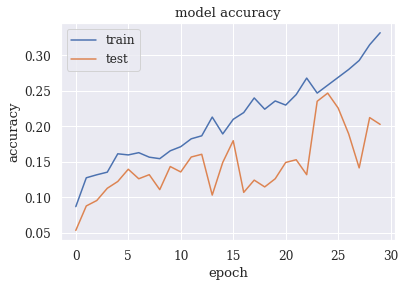

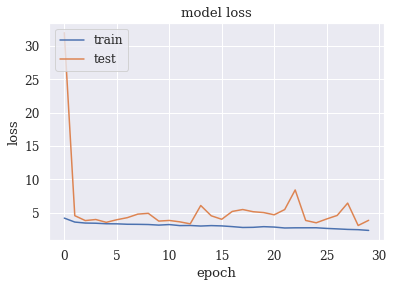

              precision    recall  f1-score   support

           0       0.08      0.06      0.07        34
           1       0.33      0.06      0.10        34
           2       0.00      0.00      0.00        34
           3       0.20      0.06      0.09        34
           4       0.21      0.47      0.29        34
           5       0.42      0.41      0.42        34
           6       0.20      0.53      0.29        34
           7       0.13      0.09      0.11        33
           8       0.20      0.30      0.24        33
           9       0.09      0.03      0.05        33
          10       0.00      0.00      0.00        32
          11       0.12      0.53      0.19        32
          12       0.11      0.06      0.08        32
          13       0.26      0.56      0.36        32
          14       1.00      0.03      0.06        32
          15       0.00      0.00      0.00        32
          16       0.20      0.03      0.05        32
          17       0.32    

In [57]:
score = model4.evaluate(X_test, y_test, verbose=1)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

from sklearn import metrics
label_pred = model4.predict(X_test)
pred = []

for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index


print(metrics.classification_report(Y_test, pred))

### Inception V3 

In [99]:
#The structure of Inception V3 architecture is imported
#We will include the weights of the already trained model on ImageNet.

ResNet50V2m=0
#ResNet50V2m=applications.ResNet50V2(weights= 'imagenet')
ResNet50V2m=applications.ResNet50V2()
ResNet50V2m.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_31[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [117]:
model5 = Sequential()

# for layer in ResNet50V2m.layers:
#     #layer.trainable= False
#     print(layer,layer.trainable)

# a softmax classifier


model5.add(ResNet50V2m)
model5.add(Dropout(0.2))
model5.add(Dense(N_Breeds))
model5.add(Activation("softmax"))

In [118]:
model5.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=[tf.keras.metrics.CategoricalAccuracy()])
history = model5.fit(X_train, y_train, batch_size=Batch_Size, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
33/33 [==============================] - 304s 9s/step - loss: 2.9959 - categorical_accuracy: 0.0503 - val_loss: 2.9970 - val_categorical_accuracy: 0.0421
Epoch 2/100
33/33 [==============================] - 259s 8s/step - loss: 2.9958 - categorical_accuracy: 0.0402 - val_loss: 2.9969 - val_categorical_accuracy: 0.0421
Epoch 3/100
33/33 [==============================] - 255s 8s/step - loss: 2.9947 - categorical_accuracy: 0.0503 - val_loss: 2.9952 - val_categorical_accuracy: 0.0344
Epoch 4/100
33/33 [==============================] - 284s 9s/step - loss: 2.9925 - categorical_accuracy: 0.0608 - val_loss: 2.9929 - val_categorical_accuracy: 0.0727
Epoch 5/100
33/33 [==============================] - 266s 8s/step - loss: 2.9876 - categorical_accuracy: 0.0699 - val_loss: 2.9977 - val_categorical_accuracy: 0.0516
Epoch 6/100
33/33 [==============================] - 285s 9s/step - loss: 2.9812 - categorical_accuracy: 0.0804 - val_loss: 2.9997 - val_categorical_accuracy: 0.0497
Epoc

21/21 [==============================] - 17s 826ms/step - loss: 2.6539 - categorical_accuracy: 0.1865

Test score/loss: 2.65385365486145
Test accuracy: 0.18654434382915497
dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


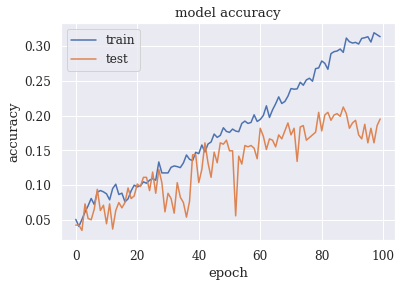

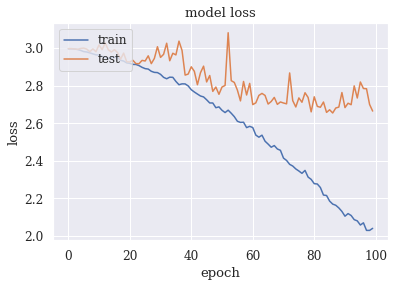

              precision    recall  f1-score   support

           0       0.07      0.18      0.10        34
           1       0.14      0.41      0.21        34
           2       0.00      0.00      0.00        34
           3       0.08      0.03      0.04        34
           4       0.32      0.47      0.38        34
           5       0.24      0.71      0.36        34
           6       0.15      0.06      0.09        34
           7       0.20      0.06      0.09        33
           8       0.17      0.03      0.05        33
           9       0.00      0.00      0.00        33
          10       0.15      0.06      0.09        32
          11       0.13      0.34      0.19        32
          12       0.20      0.03      0.05        32
          13       0.32      0.38      0.35        32
          14       0.17      0.09      0.12        32
          15       0.00      0.00      0.00        32
          16       0.00      0.00      0.00        32
          17       0.35    

In [119]:
score = model5.evaluate(X_test, y_test, verbose=1)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

from sklearn import metrics
label_pred = model5.predict(X_test)
pred = []

for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index


print(metrics.classification_report(Y_test, pred))

In [75]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

modelX = ResNet50(weights='imagenet')

img_path = 'C:/Users/gabri/Pictures/UNSCH.jpg'
img = image.load_img(img_path, target_size=(224, 224))
A = image.img_to_array(img)
B = np.expand_dims(A, axis=0)
x = preprocess_input(B)

preds = modelX.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=5)[0])

Predicted: [('n02097047', 'miniature_schnauzer', 0.9138423), ('n02097209', 'standard_schnauzer', 0.067116186), ('n02097130', 'giant_schnauzer', 0.014285855), ('n02097298', 'Scotch_terrier', 0.0029934642), ('n02093859', 'Kerry_blue_terrier', 0.0003439624)]


In [76]:

from sklearn import metrics
label_pred = modelX.predict(X_test)
pred = []

for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index


print(metrics.classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      34.0
           1       0.00      0.00      0.00      34.0
           2       0.00      0.00      0.00      34.0
           3       0.00      0.00      0.00      34.0
           4       0.00      0.00      0.00      34.0
           5       0.00      0.00      0.00      34.0
           6       0.00      0.00      0.00      34.0
           7       0.00      0.00      0.00      33.0
           8       0.00      0.00      0.00      33.0
           9       0.00      0.00      0.00      33.0
          10       0.00      0.00      0.00      32.0
          11       0.00      0.00      0.00      32.0
          12       0.00      0.00      0.00      32.0
          13       0.00      0.00      0.00      32.0
          14       0.00      0.00      0.00      32.0
          15       0.00      0.00      0.00      32.0
          16       0.00      0.00      0.00      32.0
          17       0.00    

C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [ ]:
history = InceptionV3.fit(X_train, y_train, batch_size=Batch_Size, epochs=Epochs, verbose=1, validation_split=0.2)
